**What we want:**
1. Specify number of computers for Dask?
2. 

In [96]:
# !pip install -q wandb
# !pip install datasets
# !pip install seqeval
# !pip install evaluate
# !pip install datasets transformers==4.28.0
# !pip install transformers[torch]
# !pip install dask
# !pip install dask distributed
# !pip install dask-pytorch-ddp

In [34]:
import pandas as pd
from datasets import load_dataset, load_from_disk
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import evaluate
import matplotlib.pyplot as plt
import torch
from collections import Counter
from tqdm import tqdm
import wandb
import time
import os

# Dask
import dask
import dask.dataframe as dd
import dask.delayed as delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client


# Torch Dataset

In [20]:
ds_dict = load_dataset("midas/inspec", "extraction")


ds_dict.save_to_disk("./data/", num_shards={"train": 512, "test": 8})
# Can set max_shard_size, num_shards. Equivalent to TFData (using Apache arrow format)
# Arrow format is memory-mapped from disk (like TFRecords) to prevent memory 
# Can also be loaded from GCS bucket
ds_dict = load_from_disk("./data/")

ds_dict.data

Repo card metadata block was not found. Setting CardData to empty.
Saving the dataset (512/512 shards): 100%|█| 1000/1000 [00:00<00:00, 1009.30 exa
Saving the dataset (8/8 shards): 100%|█| 500/500 [00:00<00:00, 27511.93 examples
Saving the dataset (1/1 shards): 100%|█| 500/500 [00:00<00:00, 43794.68 examples


{'train': ConcatenationTable
 id: int64
 document: list<item: string>
   child 0, item: string
 doc_bio_tags: list<item: string>
   child 0, item: string
 ----
 id: [[1001,1002],[1000,100],...,[969],[950]]
 document: [[["A","conflict","between","language","and",...,"LOT",",","on","the","other"],["Selective","representing","and","world-making","We",...,"threat","to","the","realist","conception"]],[["Does","classicism","explain","universality","?",...,"explained","by","a","classical","theory"],["Separate","accounts","go","mainstream","-LSB-",...,"to","pick","independent","money","managers"]],...,[["Controlled","projective","synchronization","in","nonpartially-linear",...,"demonstrated","in","a","hyperchaotic","system"]],[["Quantum","sensitive","dependence","Wave","functions",...,"types","of","growth","is","characterized"]]]
 doc_bio_tags: [[["O","O","O","O","O",...,"B","O","O","O","O"],["B","I","O","O","O",...,"O","O","O","O","O"]],[["O","B","O","B","O",...,"O","O","O","O","O"],["O","O",

In [47]:
# Convert each Dataset within the dataset_dict to a DataFrame
# Then convert each DataFrame to .csv for flexible loading
dfs = []
keys = list(ds_dict.keys())
for k in keys:
    dfs.append(ds_dict[k].to_pandas())
for i in range(len(dfs)):
    dfs[i].to_csv(f"./data/df_{keys[i]}.csv", index=False);
os.listdir("./data/")

['dataset_dict.json',
 'test',
 'df_validation.csv',
 'train',
 'df_test.csv',
 'validation',
 'df_train.csv']

### Dataloading with Dask

In [88]:
df_paths = [e for e in os.listdir("./data/") if e[-3:]=='csv']
df_dict = {}
for path in df_paths:
    df_dict[path[3:-4]] = dd.read_csv("./data/" + path, blocksize=2e5, engine='python')
# Picked an arbitrarily small blocksize to demonstrate partitions

In [89]:
file_size = os.path.getsize("./data/df_validation.csv")
print("File Size is :", file_size/(1000*1000), "Megs")

File Size is : 0.829862 Megs


In [90]:
df_dict['train']

,id,document,doc_bio_tags
npartitions=8,,,
,int64,string,string
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


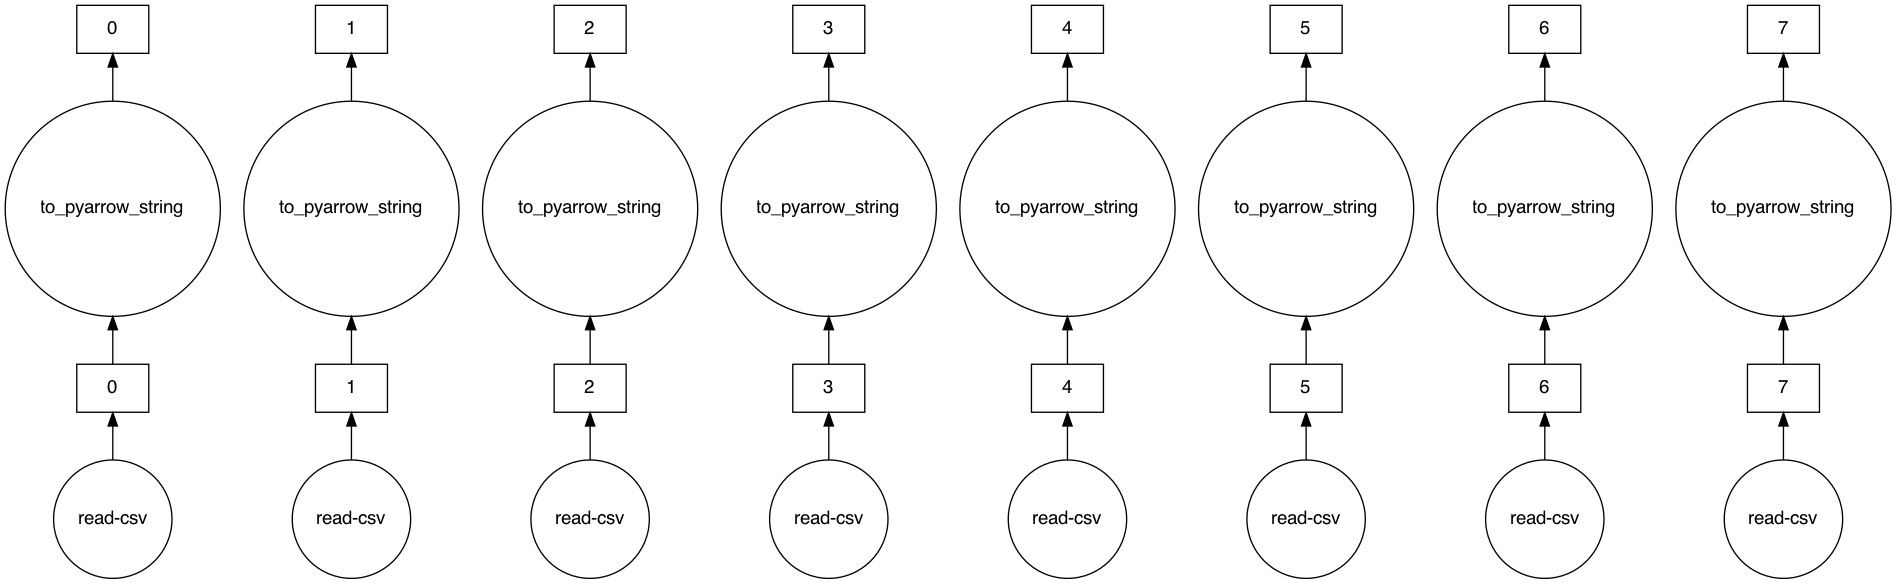

In [91]:
df_dict['train'].visualize()

In [95]:
keys = list(df_dict.keys())
for k in keys:
    print('====================================================')
    print('df_{}:\n=========================================================='.format(k))
    print(df_dict[k])
    print('\n{}\n'.format(df_dict[k].shape))

df_validation:
Dask DataFrame Structure:
                  id document doc_bio_tags
npartitions=4                             
               int64   string       string
                 ...      ...          ...
                 ...      ...          ...
                 ...      ...          ...
                 ...      ...          ...
Dask Name: to_pyarrow_string, 2 graph layers

(Delayed('int-14f79553-00f7-44b7-a6e4-5483be28fcc3'), 3)

df_test:
Dask DataFrame Structure:
                  id document doc_bio_tags
npartitions=4                             
               int64   string       string
                 ...      ...          ...
                 ...      ...          ...
                 ...      ...          ...
                 ...      ...          ...
Dask Name: to_pyarrow_string, 2 graph layers

(Delayed('int-bdb58ad0-b1c1-4e56-8613-e8b25bc06efc'), 3)

df_train:
Dask DataFrame Structure:
                  id document doc_bio_tags
npartitions=8                      